# Virtual Engineering with Optimization

The first step is to select "Cell" > "Run All" from the toolbar.  This will initialize all the widgets and allow you to interact with the unit operation options via the GUI controls.

<img src="docs/figures/three_unit_flow.png" alt="flowchart" width="800"/>

In [1]:
from ipywidgets import *
from IPython.display import HTML, clear_output
import os
import numpy as np

# imports from vebio modules
from vebio.WidgetFunctions import WidgetCollection, OptimizationWidget
from vebio.Utilities import get_host_computer
from vebio.RunFunctions import Pretreatment, Feedstock, EnzymaticHydrolysis, Bioreactor
from vebio.OptimizationFunctions import Optimization

#================================================================
# See if we're running on Eagle or on a laptop
hpc_run = get_host_computer()
#================================================================

It looks like you're running this notebook on a laptop.
Operations requiring HPC resources will be disabled.


## Set Virtual Engineering Options
### 0. Feedstock properties
Set the feedstock properties.

In [2]:
#================================================================
# Create the collection of widgets for feedstock options
fs_options = WidgetCollection()

fs_options.xylan_solid_fraction = widgets.BoundedFloatText(
    value = 0.263,
    max = 1,
    min = 0,
    description = r'Initial $X_X$',
    tooltip = 'The initial fraction of solids that is xylan (kg/kg).  Must be in the range [0, 1]'
)

fs_options.glucan_solid_fraction = widgets.BoundedFloatText(
    value = 0.40,
    max = 1,
    min = 0,
    description = r'Initial $X_G$',
    tooltip = 'The initial fraction of solids that is glucan (kg/kg).  Must be in the range [0, 1]'
)

initial_porosity_options = {'value': 0.8,
    'max': 1,
    'min': 0.5,
    'description': r'Initial Porosity',
    'tooltip': 'The initial porous fraction of the biomass particles.  Must be in the range [0, 1]'
}

fs_options.initial_porosity = OptimizationWidget('BoundedFloatText', initial_porosity_options)


#================================================================
# Display the widgets
fs_options.display_all_widgets()
#================================================================

### 1. Pretreatment Operation

Set the options for the pretreatment operation below.

In [3]:
#================================================================
# Create the collection of widgets for pretreatment options
pt_options = WidgetCollection()

initial_acid_conc_options = {'value': 0.0001,
    'max': 0.001,
    'min': 0.00005,
    'description': 'Acid Loading',
    'tooltip': 'The initial concentration of acid (mol/mL).  Must be in the range [0, 1]'}

#### this needs to be changed to g acid / g bone-dry biomass (then converted in the run function) ####
pt_options.initial_acid_conc = OptimizationWidget('BoundedFloatText', initial_acid_conc_options, controlvalue=True)

steam_temperature_options = {'value': 150.0,
    'max': 250.3,
    'min': 3.8,
    'description': 'Steam Temperature',
    'tooltip': r'The fixed temperature of the steam ($^\circ$C).',
}
pt_options.steam_temperature = OptimizationWidget('BoundedFloatText', steam_temperature_options)
# Conversion from celsius to kelvin
pt_options.steam_temperature.scaling_fn = lambda C : C + 273.15


initial_solid_fraction_options = {'value': 0.745,
    'max': 0.99,
    'min': 0.01,
    'description': r'Initial FIS$_0$',
    'tooltip': 'The initial fraction of insoluble solids (kg/kg).  Must be in the range [0, 1]'
}
pt_options.initial_solid_fraction = OptimizationWidget('BoundedFloatText', initial_solid_fraction_options)

final_time_options = {'value': 8.3,
    'max': 1440,
    'min': 1,
    'description': 'Final Time',
    'tooltip': r'Total simulation time (min).  Must be $\geq$ 1'
}
pt_options.final_time = OptimizationWidget('BoundedFloatText', final_time_options)
# Conversion from minutes to seconds
pt_options.final_time.scaling_fn = lambda s : 60.0 * s

pt_options.show_plots = widgets.Checkbox(
    value = False,
    tooltip = 'Show Plots'
)

#================================================================
# Display the widgets
pt_options.display_all_widgets()
#================================================================

---

### 2. Enzymatic Hydrolysis Operation

Set the options for the enzymatic hydrolysis operation using either a two-phase reaction rate model or high-fidelity CFD below.


In [4]:
#================================================================
# Create the collection of widgets
eh_options = WidgetCollection()

eh_options.model_type = widgets.RadioButtons(
    options = ['Lignocellulose Model', 'CFD Surrogate', 'CFD Simulation'],
    value = 'CFD Surrogate',
    description = 'Model Type',
    disabled = False,
    tooltip = 'Specifies the solver to use for the EH step, "CFD Simulation" requires HPC resources.'
)

lambda_e_options = {'value': 30.0,
    'max': 300.0,
    'min': 5.0,
    'description': 'Enzymatic Load',
    'tooltip': 'Ratio of the enzyme mass to the total solution mass (mg/g).  Must be in the range [0, 1000]'
}
eh_options.lambda_e = OptimizationWidget('BoundedFloatText', lambda_e_options, controlvalue=True)
# Conversion from mg/g to kg/kg
eh_options.lambda_e.scaling_fn = lambda e : 0.001 * e

eh_options.fis_0 = widgets.BoundedFloatText(
    value = 0.05,
    max = 1.0,
    min = 0.1,
    description = r'FIS$_0$ Target',
    tooltip = 'The target value for initial fraction of insoluble solids *after* dilution (kg/kg).  Must be in the range [0, 1]'
)
eh_options.t_final = widgets.BoundedFloatText(
    value = 24.0,
    min = 1.0,
    max = 24.0,
    description = 'Final Time',
    tooltip = r'The total time of the simulation (h).  Must be $\geq$ 1'
)

eh_options.show_plots = widgets.Checkbox(
    value = False,
    tooltip = 'Show Plots',
    disabled = True,
)

#================================================================
# Display the widgets
eh_options.display_all_widgets()
#================================================================

def model_type_action(change):
        
    if eh_options.model_type.value == 'Lignocellulose Model':
        eh_options.show_plots.value = False
        eh_options.show_plots.disabled = False
        eh_options.show_plots.tooltip = 'Show Plots'

    else: # Surrogate Model, CFD Simulation
        eh_options.show_plots.value = False
        eh_options.show_plots.disabled = True
        eh_options.show_plots.tooltip = 'Show Plots (Only available for lignocellulose model)'

eh_options.model_type.observe(model_type_action, names='value')

---

### 3. Bioreaction Operation

Set the options for the bubble column bioreaction operation below.


In [5]:
#================================================================
# Create the collection of widgets
br_options = WidgetCollection()

br_options.model_type = widgets.RadioButtons(
    options = ['CFD Surrogate', 'CFD Simulation'],
    value = 'CFD Surrogate',
    description = 'Model Type',
    disabled = False,
    tooltip = 'Specifies the solver to use for the bioreaction step, "CFD Simulation" requires HPC resources.'
)

br_options.gas_velocity = widgets.BoundedFloatText(
    value = 0.08, 
    min = 0.01,
    max = 0.1,
    description = 'Gas velocity',
    tooltip = r'Gas velocity in the simulation (m/s).  Must be in $[0.01, 0.1]$'
)

br_options.column_height = widgets.BoundedFloatText(
    value = 40., 
    min = 10.,
    max = 50.,
    description = 'Column height',
    tooltip = r'Column height (m).  Must be in $[10, 50]$'
)

br_options.column_diameter = widgets.BoundedFloatText(
    value = 5.0, 
    min = 1.,
    max = 6.,
    description = 'Column diameter',
    tooltip = r'Column diameter (m).  Must be in $[1, 6]$'
)

br_options.bubble_diameter = widgets.BoundedFloatText(
    value = 0.006,
    min = 0.003,
    max = 0.008,
    description = 'Bubble diameter',
    tooltip = r'Bubble diameter (m).  For surragate model must be in $[0.003, 0.008]$, for cfd must be $>=0$'
)

br_options.t_final = widgets.BoundedFloatText(
    value = 100.0, # default 500
    min = 1.0,
    max = 1e16,
    description = 'Final Time',
    tooltip = r'The total time of the simulation (s).  Must be $\geq 1$'
)

#================================================================
# Display the widgets
br_options.display_all_widgets()

---

### Choosing objective for optimization

In [6]:
obj_widget = widgets.Dropdown(
    options=[('Biorector:            OUR',   ('br_out', 'our')), 
             ('Enzymatic Hydrolysis: rho_g', ('eh_out', 'rho_g')), 
             ('Enzymatic Hydrolysis: rho_x', ('eh_out', 'rho_x')),
             ('Enzymatic Hydrolysis: rho_sL',('eh_out', 'rho_sL')),
             ('Enzymatic Hydrolysis: rho_f', ('eh_out', 'rho_f')),
             ('Pretreatment:         fis_0', ('eh_out', 'fis_0')),
             ('Pretreatment:         X_X',   ('eh_out', 'X_X')),
             ('Pretreatment:         X_G',   ('eh_out', 'X_G')),
             ('Pretreatment:         rho_x', ('eh_out', 'rho_x')),
             ('Pretreatment:         rho_f', ('eh_out', 'rho_f'))
            ],
    value=('br_out', 'our'),
    description='Objective:',
    tooltip = 'Specifies the objective to use in optimization.'
)

display(obj_widget)

Dropdown(description='Objective:', options=(('Biorector:            OUR', ('br_out', 'our')), ('Enzymatic Hydr…

---

### Parameter Sweeps

In [7]:
#================================================================
sweep_button = widgets.Button(
    description = 'Run Sweep.',
    tooltip = 'Execute the model start-to-finish with the properties specified above.',
    layout =  {'width': '200px', 'margin': '25px 0px 100px 170px'}, 
    button_style = 'primary'
)
#================================================================
# run_button_output = widgets.Output()
display(sweep_button)
#================================================================

# Define a function to be executed each time the run button is pressed
def sweep_button_action(b):
    clear_output()
    display(sweep_button)
    Opt = Optimization(fs_options, pt_options, eh_options, br_options, obj_widget, hpc_run)
    Opt.parameter_grid_sweep(nn=4, results_file='sweep_params.csv')
    
sweep_button.on_click(sweep_button_action)
#===============================================================

Button(button_style='primary', description='Run Sweep.', layout=Layout(margin='25px 0px 100px 170px', width='2…

Objective "our" is in br_out.
On each iteration running n=3 models

Initializing Pretreatment Model
Initializing Enzymatic Hydrolysis Model
Initializing Bioreactor Model
Optimizing Acid Loading.
Optimizing Enzymatic Load.


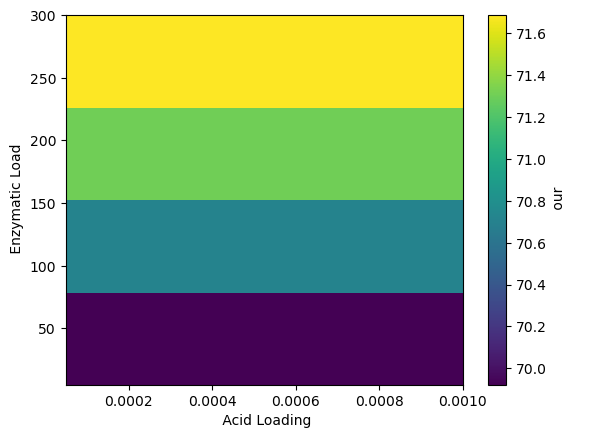

In [8]:
import matplotlib.pyplot as plt

param_sweep_fn = 'sweep_params.csv'
if os.path.exists(param_sweep_fn):
    with open(param_sweep_fn, 'r') as f:
        firstline = f.readline().split(',')
    Opt = Optimization(fs_options, pt_options, eh_options, br_options, obj_widget, hpc_run)
    sweeps = np.loadtxt(param_sweep_fn, delimiter=',', skiprows=1)
    bounds = Opt.var_real_bounds
    extent = bounds[0][0], bounds[0][1], bounds[1][0], bounds[1][1]
    nn = int(np.sqrt(len(sweeps)))
    OUR = sweeps[:, 3].reshape(nn, nn)
    shw = plt.imshow(OUR.T, extent=extent, aspect='auto', origin='lower')
    bar = plt.colorbar(shw)
    bar.set_label(firstline[-1])
    plt.xlabel(firstline[1])
    plt.ylabel(firstline[2])

 ## Optimize

Press the Optimize button below to launch the optimization of the start-to-finish operation using the above values as initial conditions.

This example **maximizes OUR** by **changing user-specified pretreatment options**.

In [9]:
opt_button = widgets.Button(
    description = 'Optimize.',
    tooltip = 'Optimize for OUR using the conditions above as an initial guess.',
    layout =  {'width': '200px', 'margin': '25px 0px 25px 170px'}, 
    button_style = 'warning'
)
#================================================================

display(opt_button)

#================================================================
# Define a function to be executed each time the run button is pressed
def opt_button_action(b):
    clear_output()
    display(opt_button)
    
    params_filename = 'virteng_params_optimization.yaml'
    opt_results_file = 'optimization_results.csv'
    
    Opt = Optimization(fs_options, pt_options, eh_options, br_options, obj_widget,
                       hpc_run)
    
    opt_result = Opt.scipy_minimize(Opt.objective_function, opt_results_file=opt_results_file)
    print(opt_result)
    
opt_button.on_click(opt_button_action)
#================================================================

Button(button_style='warning', description='Optimize.', layout=Layout(margin='25px 0px 25px 170px', width='200…

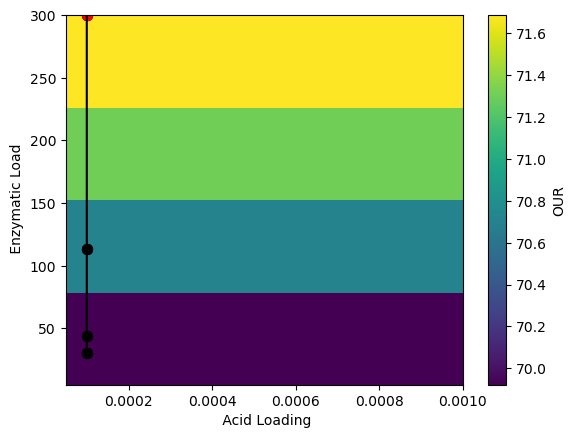

In [10]:
opt_results = np.loadtxt('optimization_results.csv', delimiter=',', skiprows=1)
shw = plt.imshow(OUR.T, extent=extent, aspect='auto', origin='lower')
bar = plt.colorbar(shw)
bar.set_label('OUR')
plt.xlabel(firstline[1])
plt.ylabel(firstline[2])
plt.scatter(opt_results[:, 1], opt_results[:, 2], s=50, c='k', marker='o')
plt.plot(opt_results[:, 1], opt_results[:, 2], color='k')
plt.scatter(opt_results[-1, 1], opt_results[-1, 2], s=50, c='r', marker='o')

---

In [11]:
# a = HTML('''<script>
# code_show=true; 
# function code_toggle() {
#  if (code_show){
#  $('div.input').hide();
#  } else {
#  $('div.input').show();
#  }
#  code_show = !code_show
# } 
# $( document ).ready(code_toggle);
# </script>
# <form action="javascript:code_toggle()"><input type="submit" \
# value="Toggle code visibility (hidden by default)."></form>''')

# display(a)

In [12]:
# # reload "run functions" code if needed
# if False:
#     from importlib import reload
#     import vebio.RunFunctions
#     reload(vebio.RunFunctions)
#     from vebio.RunFunctions import run_pretreatment, run_enzymatic_hydrolysis, run_bioreactor